#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 08
**CH08A Finding a good deal among hotels with nonlinear function**

using the hotels-vienna dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format
from plotnine import *
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")


In [2]:
# load vienna
hotels = pd.read_csv("/workspaces/codespaces-jupyter/data/hotels-vienna.csv")
#data = pd.read_csv("https://osf.io/y6jvb/download")

In [3]:
hotels = hotels.loc[
    (hotels["accommodation_type"] == "Hotel")
    & (hotels["city_actual"] == "Vienna")
    & (hotels["stars"] >= 3)
    & (hotels["stars"] <= 4)
    & (hotels["stars"].notna())
    & (hotels["price"] <= 600)
]


#### LOG MODELS

In [4]:
hotels["lnprice"] = np.log(hotels["price"])
hotels["distance2"] = hotels["distance"]
hotels.loc[hotels["distance2"] < 0.05, "distance2"] = 0.05
hotels["lndistance"] = np.log(hotels["distance2"])

In [5]:
hotels["lndistance"].describe()

count    207.000000
mean       0.098564
std        0.901424
min       -2.995732
25%       -0.223144
50%        0.262364
75%        0.641854
max        1.887070
Name: lndistance, dtype: float64

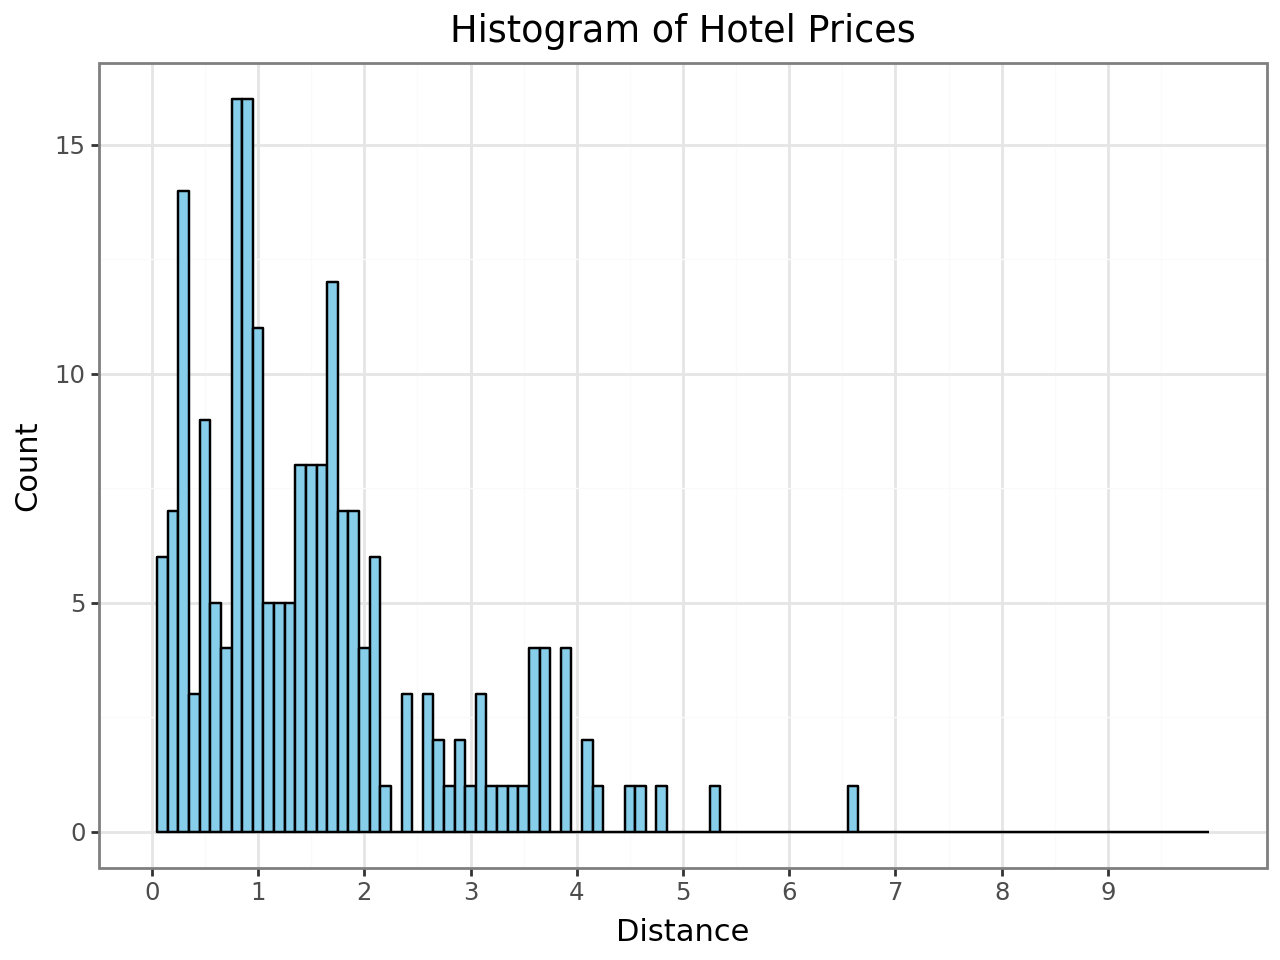

In [6]:
(
    ggplot(hotels, aes(x="distance"))
    + geom_histogram(binwidth=0.1, fill="skyblue", color="black")
    + scale_x_continuous(breaks=np.arange(0, 10, 1), limits=(0,10))
    + labs(title="Histogram of Hotel Prices", x="Distance", y="Count")
    + theme_bw()
)

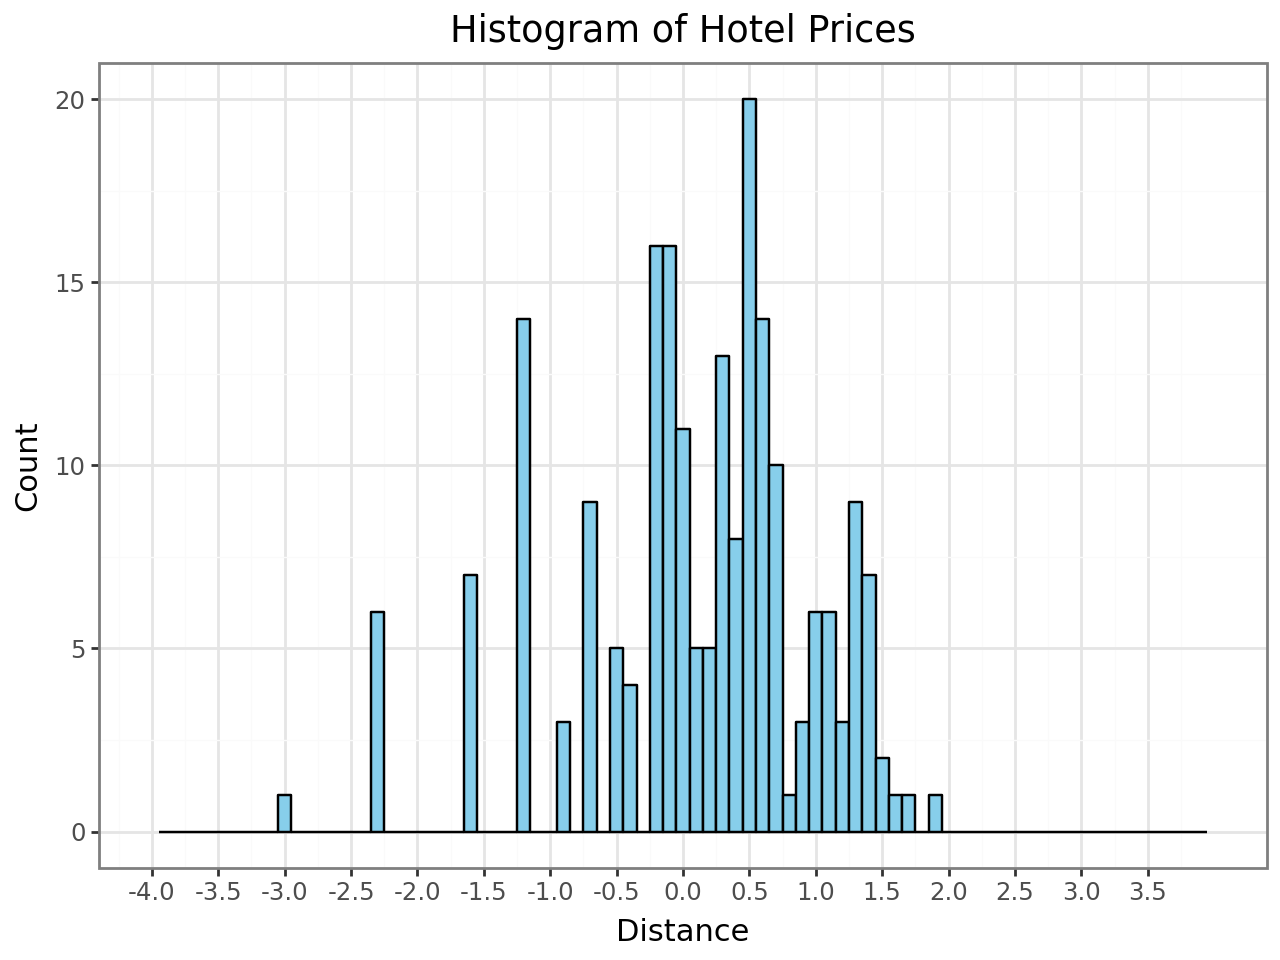

In [7]:
(
    ggplot(hotels, aes(x="lndistance"))
    + geom_histogram(binwidth=0.1, fill="skyblue", color="black")
    + scale_x_continuous(breaks=np.arange(-4, 4, 0.5), limits=(-4,4))
    + labs(title="Histogram of Hotel Prices", x="Distance", y="Count")
    + theme_bw()
)

## Create spline variables



In [8]:
cutoff = 1.5
cutoff_ln = np.log(cutoff)
cutoff_ln

hotels["dist_spline"] = np.where(hotels["distance"] > cutoff, hotels["distance"] - cutoff, 0)
hotels["dist_ln_spline"] = np.where(hotels["lndistance"] > cutoff_ln, hotels["lndistance"] - cutoff_ln, 0)

hotels

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,distance,distance_alter,accommodation_type,nnights,rating,lnprice,distance2,lndistance,dist_spline,dist_ln_spline
1,Austria,Vienna,189.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,3.5,...,1.7,3.8,Hotel,1,3.9,4.394449,1.7,0.530628,0.2,0.125163
2,Austria,Vienna,53.0,City centre,Donauturm,Alsergrund,85,Vienna,4.0,3.5,...,1.4,2.5,Hotel,1,3.7,4.442651,1.4,0.336472,0.0,0.000000
3,Austria,Vienna,55.0,City centre,Donauturm,Alsergrund,83,Vienna,3.0,4.0,...,1.7,2.5,Hotel,1,4.0,4.418841,1.7,0.530628,0.2,0.125163
4,Austria,Vienna,33.0,City centre,Donauturm,Alsergrund,82,Vienna,4.0,3.5,...,1.2,2.8,Hotel,1,3.9,4.406719,1.2,0.182322,0.0,0.000000
6,Austria,Vienna,57.0,City centre,Donauturm,Alsergrund,103,Vienna,4.0,3.5,...,0.9,2.4,Hotel,1,3.9,4.634729,0.9,-0.105361,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,Austria,Vienna,77.0,City centre,Donauturm,Wieden,100,Vienna,3.0,4.0,...,1.2,3.7,Hotel,1,4.0,4.605170,1.2,0.182322,0.0,0.000000
421,Austria,Vienna,572.0,City centre,Donauturm,Wieden,95,Vienna,4.0,4.0,...,1.5,3.9,Hotel,1,4.1,4.553877,1.5,0.405465,0.0,0.000000
422,Austria,Vienna,53.0,City centre,Donauturm,Wieden,73,Vienna,3.0,3.0,...,1.5,4.0,Hotel,1,3.4,4.290459,1.5,0.405465,0.0,0.000000
425,Austria,Vienna,112.0,City centre,Donauturm,Wieden,100,Vienna,4.0,4.5,...,1.0,3.7,Hotel,1,4.4,4.605170,1.0,0.000000,0.0,0.000000


## Level-Level Regressions

### Linear

In [9]:
lin_reg = smf.ols(formula="price ~ distance", data=hotels)
lin_reg.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     38.20
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           3.39e-09
Time:                        18:45:14   Log-Likelihood:                -1050.3
No. Observations:                 207   AIC:                             2105.
Df Residuals:                     205   BIC:                             2111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.0170      4.474     29.511      0.000     123.197     140.837
distance     -14.4064      2.331     -6.181      0.000     -19.002      -9.811
==============================================================================
Omnibus:                      141.994   Durbin-Watson:                   1.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1560.025
Skew:                           2.497   Prob(JB):                         0.00
Kurtosis:                      15.488   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Linear Spine

In [10]:
splin_reg = smf.ols(formula="price ~ distance + dist_spline", data=hotels)
splin_reg.fit().summary()
hotels["sppred"] = splin_reg.fit().predict()
splin_reg.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     39.14
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           4.09e-15
Time:                        18:45:14   Log-Likelihood:                -1034.4
No. Observations:                 207   AIC:                             2075.
Df Residuals:                     204   BIC:                             2085.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     160.6503      6.434     24.970      0.000     147.965     173.335
distance      -47.0912      6.012     -7.832      0.000     -58.946     -35.237
dist_spline    47.2668      8.112      5.827      0.000      31.272      63.262
==============================================================================
Omnibus:                      182.761   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4119.666
Skew:                           3.241   Prob(JB):                         0.00
Kurtosis:                      23.872   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Qudratic

In [11]:
hotels["qadr_dist"] = hotels["distance"].pow(2)
qudr_reg = smf.ols(formula="price ~ distance + qadr_dist", data=hotels)
qudr_reg.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     35.44
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           6.18e-14
Time:                        18:45:14   Log-Likelihood:                -1037.1
No. Observations:                 207   AIC:                             2080.
Df Residuals:                     204   BIC:                             2090.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    154.8580      6.045     25.617      0.000     142.939     166.777
distance     -46.0140      6.394     -7.197      0.000     -58.620     -33.408
qadr_dist      6.9277      1.316      5.263      0.000       4.332       9.523
==============================================================================
Omnibus:                      177.585   Durbin-Watson:                   1.551
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3582.408
Skew:                           3.149   Prob(JB):                         0.00
Kurtosis:                      22.382   Cond. No.                         23.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Cubic

In [12]:
hotels["cub_dist"] = hotels["distance"].pow(3)
cub_reg = smf.ols(formula="price ~ distance + cub_dist", data=hotels)
cub_reg.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     30.96
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           1.81e-12
Time:                        18:45:14   Log-Likelihood:                -1040.6
No. Observations:                 207   AIC:                             2087.
Df Residuals:                     204   BIC:                             2097.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    145.7398      5.258     27.716      0.000     135.372     156.107
distance     -28.8451      3.914     -7.370      0.000     -36.562     -21.129
cub_dist       0.7115      0.159      4.489      0.000       0.399       1.024
==============================================================================
Omnibus:                      167.692   Durbin-Watson:                   1.518
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2887.622
Skew:                           2.954   Prob(JB):                         0.00
Kurtosis:                      20.317   Cond. No.                         75.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plots

### Linear

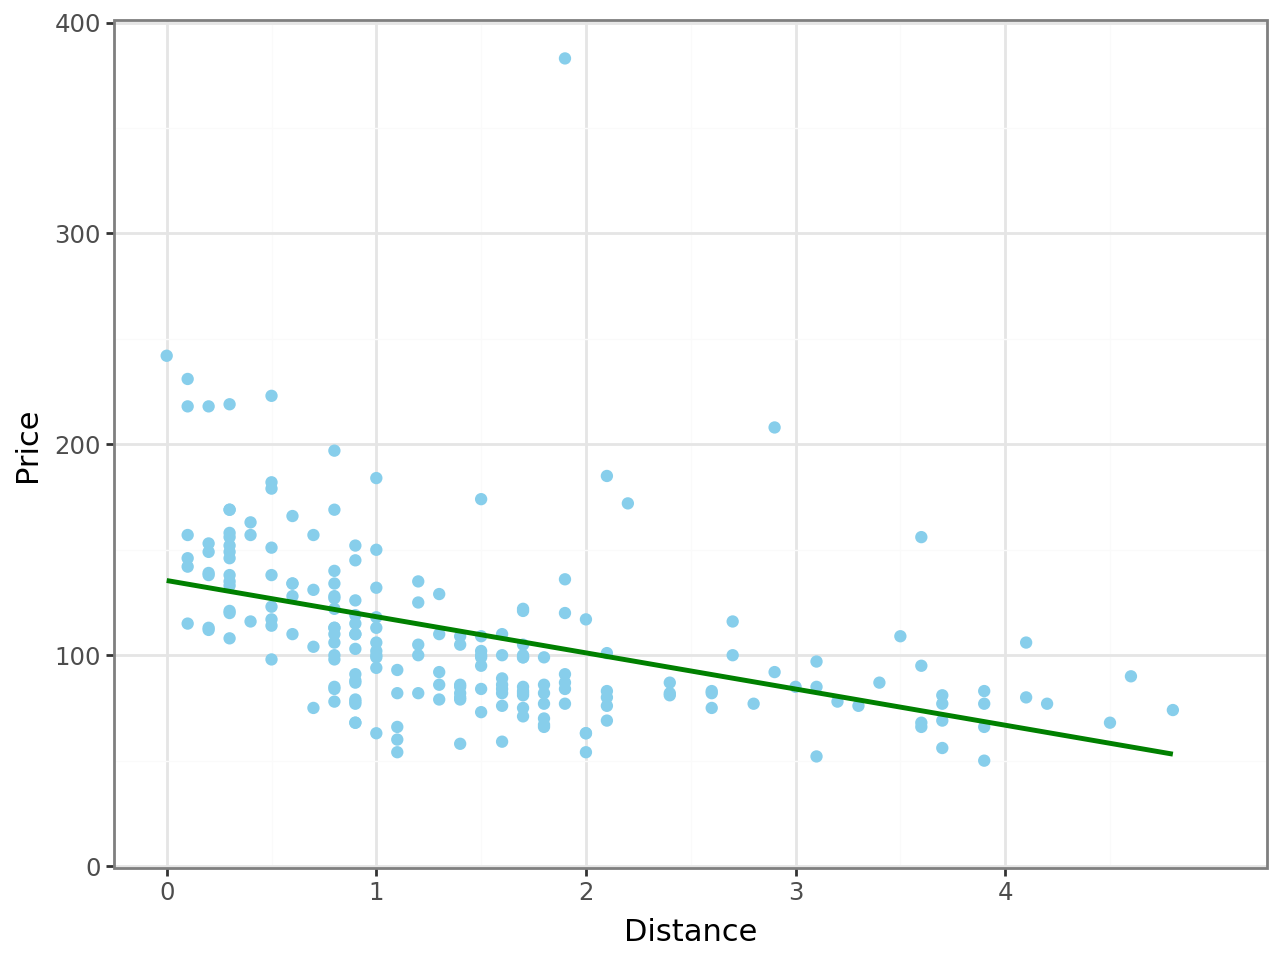

In [ ]:
(
    ggplot(hotels, aes(x="distance", y="price"))
    + geom_point(color="skyblue")
    + geom_smooth(color="green", method="lm", se=False)
    + coord_cartesian(ylim=(0, 400))
    + scale_x_continuous(breaks=np.arange(0, 5, 1), limits=(0, 5))
    + scale_y_continuous(expand=(0, 1), limits=(0, 400))
    + labs(x="Distance", y="Price")
    + theme_bw()
)

### Line Spine

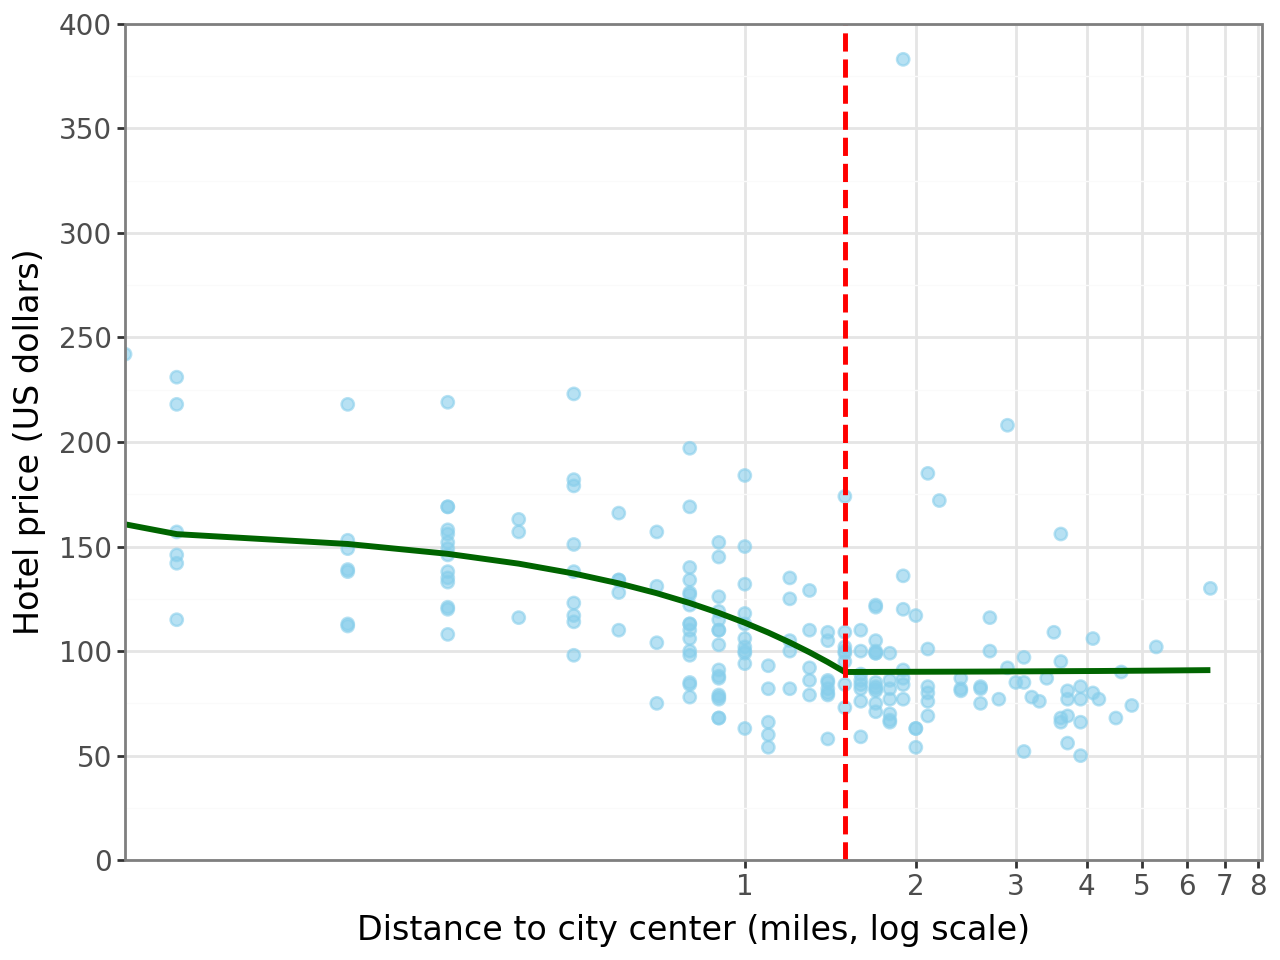

In [14]:
(
    ggplot(hotels, aes(x="distance", y="price"))
    + geom_point(color="skyblue", alpha=0.6, size=2)
    + geom_line(aes(y="sppred"), color="darkgreen", size=1.2)
    + geom_vline(xintercept=cutoff, color="red", size=1, linetype="dashed")
    + coord_cartesian(ylim=(0, 400))
    + scale_x_continuous(
        trans=log_trans(),
        breaks=np.arange(0, 10, 1),
        labels=log_format(),
        name="Distance to city center (miles, log scale)"
    )
    + scale_y_continuous(
        expand=(0, 0),
        breaks=np.arange(0, 401, 50),
        name="Hotel price (US dollars)"
    )
    + labs(
        x="Distance to city center (miles, log scale)",
        y="Hotel price (US dollars)"
    )
    + theme_bw()
    + theme(
        plot_title=element_text(size=14, weight="bold"),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10)
    )
)

### Quadratic


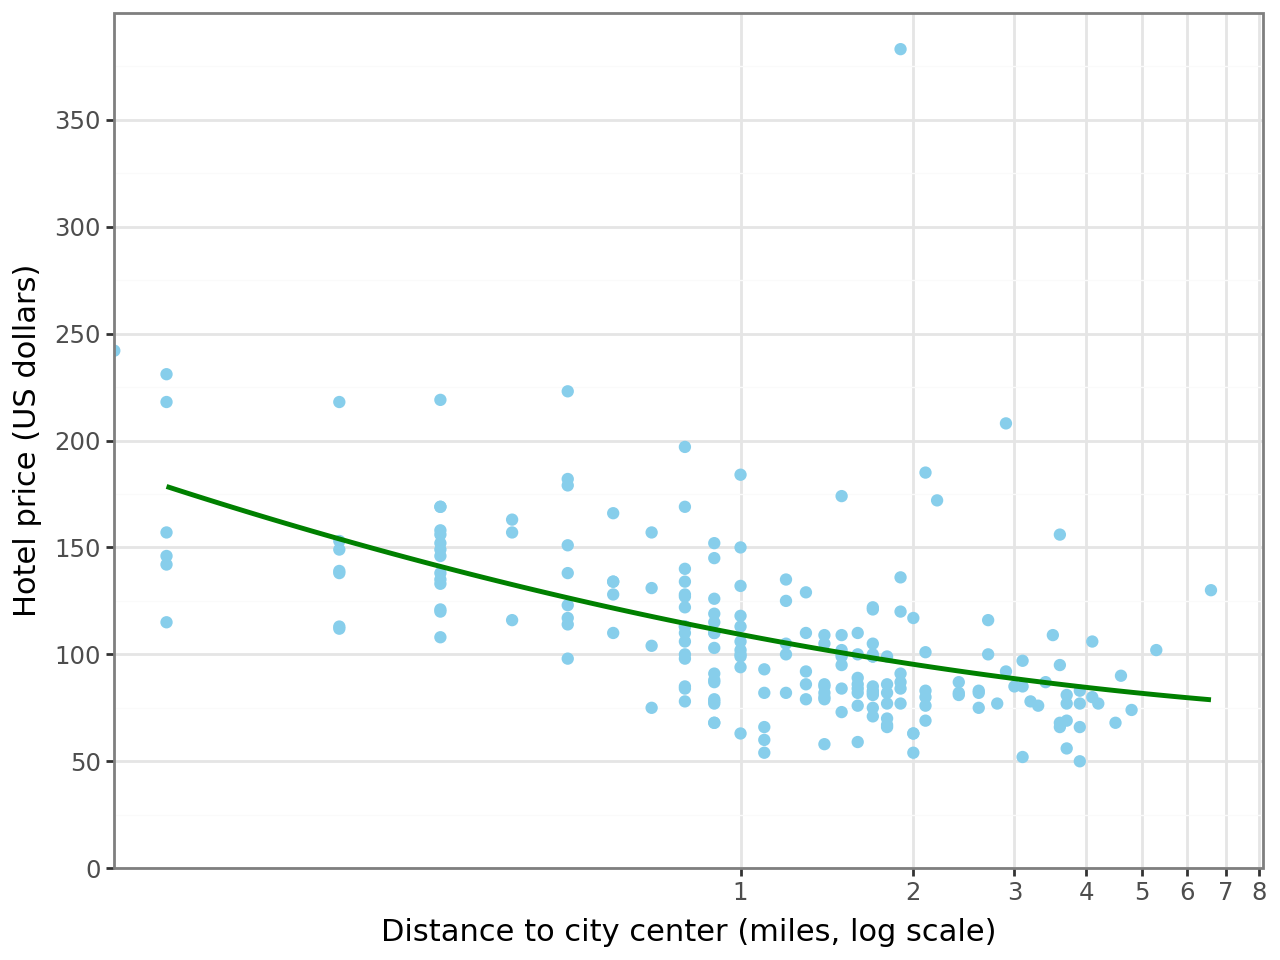

In [15]:
(
    ggplot(hotels, aes(x="distance", y="price"))
    + geom_point(color="skyblue")
    + geom_smooth(
        method="lm",
        formula="y ~ x + I(x**2)",
        color="green",
        se=False,
        size=1
    )
    + coord_cartesian(ylim=(0, 400))
    + scale_x_continuous(
        trans=log_trans(),
        breaks=np.arange(0, 10, 1),
        labels=log_format(),
        name="Distance to city center (miles, log scale)"
    )
    + scale_y_continuous(expand=(0,0), breaks=np.arange(0, 400, 50))
    + labs(
        x="Distance to city center (miles, log scale)",
        y="Hotel price (US dollars)"
    )
    + theme_bw()
)

### Cubic

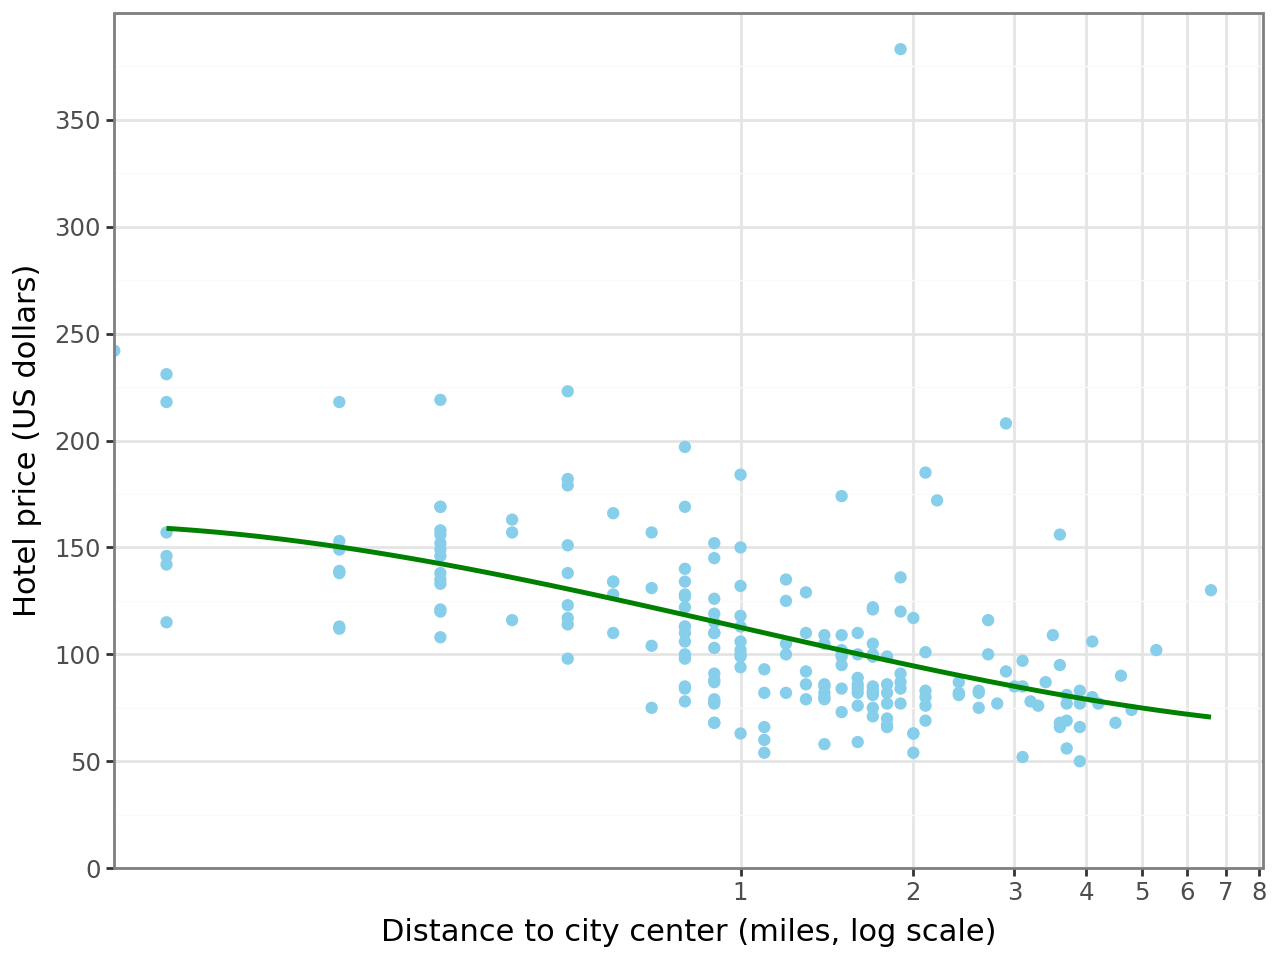

In [16]:
(
    ggplot(hotels, aes(x="distance", y="price"))
    + geom_point(color="skyblue")
    + geom_smooth(
        method="lm",
        formula="y ~ x + I(x**3)",
        color="green",
        se=False,
        size=1
    )
    + coord_cartesian(ylim=(0, 400))
    + scale_x_continuous(
        trans=log_trans(),
        breaks=np.arange(0, 10, 1),
        labels=log_format(),
        name="Distance to city center (miles, log scale)"
    )
    + scale_y_continuous(expand=(0,0), breaks=np.arange(0, 400, 50))
    + labs(
        x="Distance to city center (miles, log scale)",
        y="Hotel price (US dollars)"
    )
    + theme_bw()
)

In [17]:
hotels

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,nnights,rating,lnprice,distance2,lndistance,dist_spline,dist_ln_spline,sppred,qadr_dist,cub_dist
1,Austria,Vienna,189.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,3.5,...,1,3.9,4.394449,1.7,0.530628,0.2,0.125163,90.048617,2.89,4.913
2,Austria,Vienna,53.0,City centre,Donauturm,Alsergrund,85,Vienna,4.0,3.5,...,1,3.7,4.442651,1.4,0.336472,0.0,0.000000,94.722619,1.96,2.744
3,Austria,Vienna,55.0,City centre,Donauturm,Alsergrund,83,Vienna,3.0,4.0,...,1,4.0,4.418841,1.7,0.530628,0.2,0.125163,90.048617,2.89,4.913
4,Austria,Vienna,33.0,City centre,Donauturm,Alsergrund,82,Vienna,4.0,3.5,...,1,3.9,4.406719,1.2,0.182322,0.0,0.000000,104.140858,1.44,1.728
6,Austria,Vienna,57.0,City centre,Donauturm,Alsergrund,103,Vienna,4.0,3.5,...,1,3.9,4.634729,0.9,-0.105361,0.0,0.000000,118.268216,0.81,0.729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,Austria,Vienna,77.0,City centre,Donauturm,Wieden,100,Vienna,3.0,4.0,...,1,4.0,4.605170,1.2,0.182322,0.0,0.000000,104.140858,1.44,1.728
421,Austria,Vienna,572.0,City centre,Donauturm,Wieden,95,Vienna,4.0,4.0,...,1,4.1,4.553877,1.5,0.405465,0.0,0.000000,90.013499,2.25,3.375
422,Austria,Vienna,53.0,City centre,Donauturm,Wieden,73,Vienna,3.0,3.0,...,1,3.4,4.290459,1.5,0.405465,0.0,0.000000,90.013499,2.25,3.375
425,Austria,Vienna,112.0,City centre,Donauturm,Wieden,100,Vienna,4.0,4.5,...,1,4.4,4.605170,1.0,0.000000,0.0,0.000000,113.559097,1.00,1.000


## Log-Log Regressions

### Linear

In [19]:
lin_reg2 = smf.ols(formula="lnprice ~ lndistance", data=hotels)
lin_reg2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     102.6
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           8.18e-20
Time:                        18:46:05   Log-Likelihood:                -25.911
No. Observations:                 207   AIC:                             55.82
Df Residuals:                     205   BIC:                             62.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6615      0.019    241.926      0.000       4.623       4.699
lndistance    -0.2158      0.021    -10.130      0.000      -0.258      -0.174
==============================================================================
Omnibus:                       47.573   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.794
Skew:                           0.976   Prob(JB):                     1.08e-28
Kurtosis:                       6.335   Cond. No.                         1.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Lin Spline

In [20]:
#hotels["dist_ln_spline"] = np.where(hotels["lndistance"] > cutoff_ln, hotels["lndistance"] - cutoff_ln, 0)

splin_reg2 = smf.ols(formula="lnprice ~ lndistance + dist_ln_spline", data=hotels)
splin_reg2.fit().summary()
hotels["sppred2"] = splin_reg2.fit().predict()
splin_reg2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     54.01
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           1.50e-19
Time:                        18:47:47   Log-Likelihood:                -23.938
No. Observations:                 207   AIC:                             53.88
Df Residuals:                     204   BIC:                             63.87
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.6340      0.024    196.184      0.000       4.587       4.681
lndistance        -0.2571      0.030     -8.652      0.000      -0.316      -0.199
dist_ln_spline     0.1597      0.081      1.981      0.049       0.001       0.319
==============================================================================
Omnibus:                       50.093   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.288
Skew:                           1.008   Prob(JB):                     7.68e-32
Kurtosis:                       6.543   Cond. No.                         4.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Qudratic

In [21]:
hotels["lnqadr_dist2"] = hotels["lndistance"].pow(2)
qudr_reg2 = smf.ols(formula="lnprice ~ lndistance + lnqadr_dist2", data=hotels)
qudr_reg2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     51.90
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           6.01e-19
Time:                        18:49:52   Log-Likelihood:                -25.344
No. Observations:                 207   AIC:                             56.69
Df Residuals:                     204   BIC:                             66.69
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.6460      0.024    191.891      0.000       4.598       4.694
lndistance      -0.2067      0.023     -9.011      0.000      -0.252      -0.161
lnqadr_dist2     0.0179      0.017      1.058      0.291      -0.015       0.051
==============================================================================
Omnibus:                       47.780   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.455
Skew:                           0.980   Prob(JB):                     7.75e-29
Kurtosis:                       6.342   Cond. No.                         2.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Cubic

In [23]:
hotels["lncub_dist2"] = hotels["lndistance"].pow(3)
cub_reg2 = smf.ols(formula="lnprice ~ lndistance + lncub_dist2", data=hotels)
cub_reg2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     51.43
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           8.21e-19
Time:                        18:50:41   Log-Likelihood:                -25.661
No. Observations:                 207   AIC:                             57.32
Df Residuals:                     204   BIC:                             67.32
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.6657      0.020    231.031      0.000       4.626       4.705
lndistance     -0.2349      0.035     -6.796      0.000      -0.303      -0.167
lncub_dist2     0.0070      0.010      0.702      0.484      -0.013       0.027
==============================================================================
Omnibus:                       48.787   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.498
Skew:                           0.992   Prob(JB):                     3.78e-30
Kurtosis:                       6.432   Cond. No.                         6.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plots

### Linear

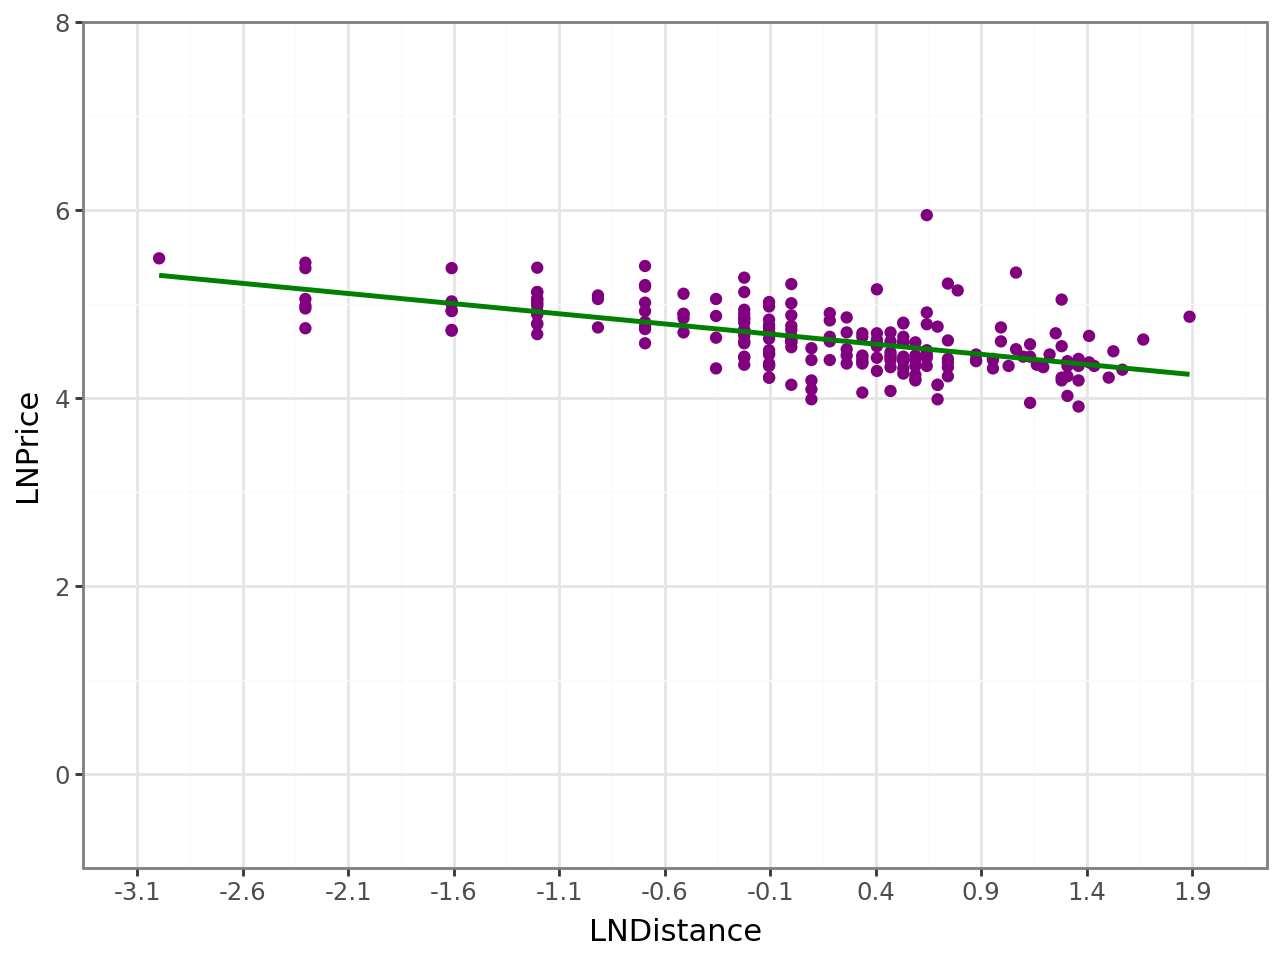

In [49]:
(
    ggplot(hotels, aes(x="lndistance", y="lnprice"))
    + geom_point(color="purple")
    + geom_smooth(color="green", method="lm", se=False)
    + coord_cartesian(ylim=(0, 7))
    + scale_x_continuous(breaks=np.arange(-3.1, 2, 0.5), limits=(-3.1, 2))
    + scale_y_continuous(expand=(0, 1), limits=(0, 7))
    + labs(x="LNDistance", y="LNPrice")
    + theme_bw()
)

### Linear Spline

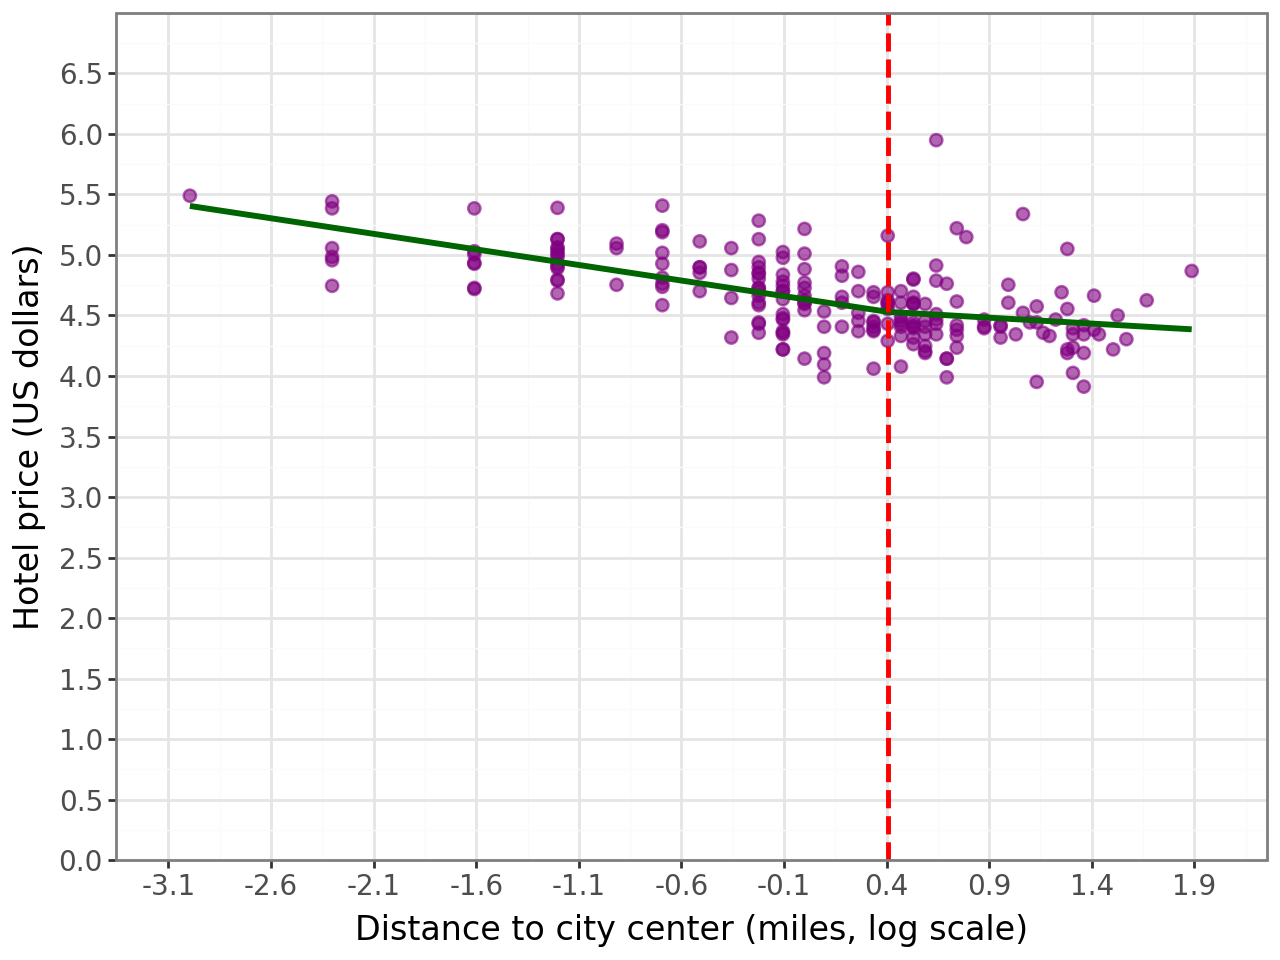

In [ ]:
(
    ggplot(hotels, aes(x="lndistance", y="lnprice"))
    + geom_point(color="purple", alpha=0.6, size=2)
    + geom_line(aes(y="sppred2"), color="darkgreen", size=1.2)
    + geom_vline(xintercept=cutoff_ln, color="red", size=1, linetype="dashed")
    + coord_cartesian(ylim=(0, 7))
    + scale_x_continuous(
        breaks=np.arange(-3.1, 2, 0.5),
        limits=(-3.1, 2),
        name="LN Distance to city center (miles, log scale)"
    )
    + scale_y_continuous(
        expand=(0, 0),
        breaks=np.arange(0, 7, 0.5),
        name="LN Hotel price (US dollars)"
    )
    + labs(
        x="LNDistance to city center (miles, log scale)",
        y="LNHotel price (US dollars)"
    )
    + theme_bw()
    + theme(
        plot_title=element_text(size=14, weight="bold"),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10)
    )
)

### Quadratic

### Cubic